In [6]:
from conch.open_clip_custom import create_model_from_pretrained, tokenize, get_tokenizer
import torch
import os
from PIL import Image
from pathlib import Path
from tqdm import tqdm

# show all jupyter output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [7]:
root = Path('../').resolve()
os.chdir(root)

In [8]:
# Load the model from "create_model_from_pretrained"
model_cfg = 'conch_ViT-B-16'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# checkpoint_path = 'checkpoints/CONCH/pytorch_model.bin'
checkpoint_path = 'C:\\Users\\Vivian\\Documents\\CONCH\\checkpoints\\conch\\pytorch_model.bin' 
model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, device=device)
_ = model.eval()

c:\Users\Vivian\Documents\CONCH\conch\open_clip_custom\factory.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map

In [ ]:
import os
import pandas as pd
import shutil

# Paths
# dataset_path = r"C:\Users\klee0\OneDrive - Queen's University\School\Data\BreaKHis_v1"
# folds_csv_path = r"C:\Users\klee0\OneDrive - Queen's University\School\Data\Folds.csv"
# output_base_path = r"C:\Users\klee0\OneDrive - Queen's University\School\Data\Folds"
dataset_path = r"C:\Users\Vivian\Documents\breakhis\BreaKHis_v1"
folds_csv_path = r"C:\Users\Vivian\Documents\breakhis\Folds.csv"
output_base_path = r"C:\Users\Vivian\Documents\CONCH\Folds"

# Read the Folds.csv file
folds_df = pd.read_csv(folds_csv_path)

# Create the fold directories
for fold in range(1, 6):
    fold_path = os.path.join(output_base_path, f"Fold {fold}")
    os.makedirs(os.path.join(fold_path, "train"), exist_ok=True)
    os.makedirs(os.path.join(fold_path, "test"), exist_ok=True)

# Organize images into the respective fold directories
for _, row in folds_df.iterrows():
    image_path = os.path.join(dataset_path, row['filename'])
    fold = row['fold']
    split = row['grp']  # 'train' or 'test'

    # Destination path
    dest_path = os.path.join(output_base_path, f"Fold {fold}", split)

    # Copy the image to the destination path
    shutil.copy(image_path, dest_path)

print("Dataset organization complete.")

In [ ]:
# Vivian - Preprocess images and save tensors
def preprocess_image(image_path):
    """
    Load and preprocess an image for the CONCH model.
    Args:
        image_path (str): Path to the input image.
    Returns:
        torch.Tensor: Preprocessed image tensor ready for CONCH model input.
    """
    image = Image.open(image_path).convert("RGB")  # Ensure 3 channels (RGB)
    return preprocess(image).unsqueeze(0)  # Add batch dimension

def preprocess_dataset(dataset_path, output_path):
    """
    Preprocess the entire BreakHis dataset and save the tensors.
    Args:
        dataset_path (str): Path to the BreakHis dataset.
        output_path (str): Path to save the processed tensors.
    """
    os.makedirs(output_path, exist_ok=True)  # Create output directory if not exist

    for root, _, files in tqdm(os.walk(dataset_path)):
        for file in files:
            if file.endswith(".png"):
                image_path = os.path.join(root, file)
                tensor = preprocess_image(image_path)

                # Save the tensor with the same name as the image
                tensor_path = os.path.join(output_path, file.replace('.png', '.pt'))
                torch.save(tensor, tensor_path)

# Example usage
dataset_path = r"C:\Users\Vivian\Documents\CONCH\Folds\Fold 5\test" # manually change for each test/train folder and each fold
output_path = r"C:\Users\Vivian\Documents\CONCH\Folds\Fold 5\test_tensors"

preprocess_dataset(dataset_path, output_path)
print("Process Complete")

1it [00:48, 48.34s/it]

Process Complete


In [ ]:
# example image for uni model - don't need to run
from PIL import Image
image = Image.open("uni.jpg")
image = transform(image).unsqueeze(dim=0) # Image (torch.Tensor) with shape [1, 3, 224, 224] following image resizing and normalization (ImageNet parameters)
with torch.inference_mode():
    feature_emb = model(image) # Extracted features (torch.Tensor) with shape [1,1024]

In [ ]:
# Feature extraction
import os
import torch
from tqdm import tqdm

def extract_features_for_folds(base_fold_path, model):
    """
    Extract features for each fold and save them in train_feature and test_feature folders.
    Args:
        base_fold_path (str): Path to the base folder containing Fold 1, Fold 2, etc.
        model (torch.nn.Module): Pretrained model for feature extraction.
    """
    for fold in range(1, 6):
        fold_path = os.path.join(base_fold_path, f"Fold {fold}")
        for split in ['train', 'test']:
            tensor_folder = os.path.join(fold_path, f"{split}_tensors")
            output_folder = os.path.join(fold_path, f"{split}_features")
            os.makedirs(output_folder, exist_ok=True)  # Create output directory if not exist

            for tensor_file in tqdm(os.listdir(tensor_folder)):
                if tensor_file.endswith(".pt"):
                    tensor_path = os.path.join(tensor_folder, tensor_file)
                    tensor = torch.load(tensor_path).to(device)

                    with torch.inference_mode():
                        # features = model(tensor) 
                        features = model.encode_image(tensor, proj_contrast=False, normalize=False) # using conch to embed images only

                    # Save the features with the same name as the tensor file
                    feature_path = os.path.join(output_folder, tensor_file.replace('.pt', '_features.pt'))
                    torch.save(features, feature_path)

# Example usage
# base_fold_path = r"C:\Users\klee0\OneDrive - Queen's University\School\Data\Folds"
base_fold_path = r"C:\Users\Vivian\Documents\CONCH\Folds"
extract_features_for_folds(base_fold_path, model)
print("Feature extraction for all folds complete.")

  0%|          | 0/5005 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_29364\904110987.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load

Feature extraction for all folds complete.


In [4]:
import os
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Define the labels
labels_list = ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']

# Function to extract label from filename
def extract_label_from_filename(filename, labels_list):
    for label in labels_list:
        if label in filename:
            return label
    return None

# Function to load features and labels
def load_features_and_labels(feature_folder, labels_list):
    features = []
    labels = []
    for feature_file in os.listdir(feature_folder):
        if feature_file.endswith("_features.pt"):
            feature_path = os.path.join(feature_folder, feature_file)
            feature = torch.load(feature_path).to('cpu').numpy()
            feature = feature.flatten()
            features.append(feature)
            label = extract_label_from_filename(feature_file, labels_list)
            if label:
                labels.append(label)
    return np.array(features), np.array(labels)

# Paths
# base_fold_path = r"C:\Users\klee0\OneDrive - Queen's University\School\Data\Folds"
base_fold_path = r"C:\Users\Vivian\Documents\CONCH\Folds"

# Initialize lists to store results
all_y_test = []
all_y_pred_prob = []

# Loop through each fold
for fold in range(1, 6):
    train_feature_folder = os.path.join(base_fold_path, f"Fold {fold}", "train_features")
    test_feature_folder = os.path.join(base_fold_path, f"Fold {fold}", "test_features")

    # Load training and testing data
    X_train, y_train = load_features_and_labels(train_feature_folder, labels_list)
    X_test, y_test = load_features_and_labels(test_feature_folder, labels_list)

    # Binarize the labels for ROC curve plotting
    y_train_bin = label_binarize(y_train, classes=labels_list)
    y_test_bin = label_binarize(y_test, classes=labels_list)

    # Train logistic regression classifier
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(X_train, y_train)

    # Predict on test data
    y_pred_prob = classifier.predict_proba(X_test)

    # Store results
    all_y_test.append(y_test_bin)
    all_y_pred_prob.append(y_pred_prob)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_27708\2149840671.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_27708\2149840671.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_27708\2149840671.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_27708\2149840671.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_27708\2149840671.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

<Figure size 1200x800 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curves')

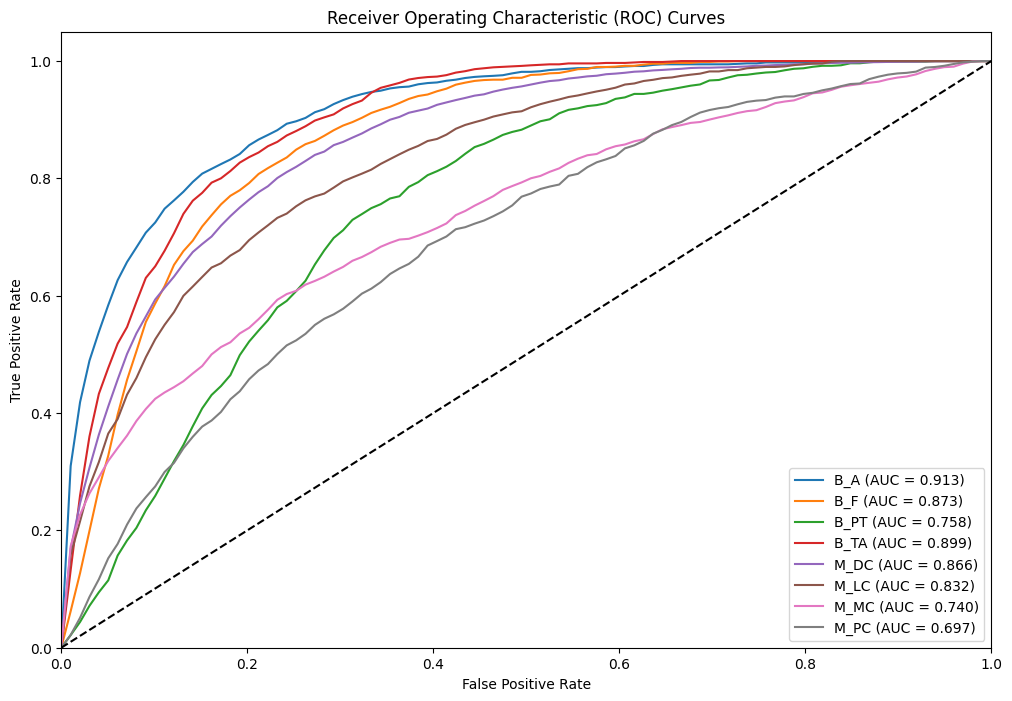

In [8]:

# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels_list):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for y_test_bin, y_pred_prob in zip(all_y_test, all_y_pred_prob):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label=f'{label} (AUC = {mean_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

Generating classification report

In [9]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the labels and classes
labels_list = ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']
classes = ["adenosis (A)", "fibroadenoma (F)", "phyllodes tumor (PT)", "tubular adenona (TA)", "carcinoma (DC)", "lobular carcinoma (LC)", "mucinous carcinoma (MC)", "papillary carcinoma (PC)"]

# Check device availability
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {device}")

# Assuming model is already defined
# model = ...

# Move model to GPU if available
model.to(device)

Running on device: cpu


CoCa(
  (text): TextTransformer(
    (token_embedding): Embedding(32007, 768)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_final): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (visual): VisualModel(
    (trunk): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kerne

In [23]:
# Function to extract label from filename
def extract_label_from_filename(filename, labels_list):
    for label in labels_list:
        if label in filename:
            return label
    return None

# Function to load features and labels from CSV files
def load_features_and_labels(feature_folder, labels_list):
    features = []
    labels = []
    print(f"Loading features from: {feature_folder}")
    for feature_file in os.listdir(feature_folder):
        if feature_file.endswith("_features.pt"):
            feat = torch.load(os.path.join(feature_folder, feature_file)).to(device)
            #feature_path = os.path.join(feature_folder, feature_file)
            #feature = pd.read_csv(feature_path).values.flatten()
            features.append(feat)
            label = extract_label_from_filename(feature_file, labels_list)
            if label:
                labels.append(label)
        else:
            print(f"Skipping file: {feature_file}")
    return np.array(features), np.array(labels)

In [28]:
base_fold_path = r"C:\Users\Vivian\Documents\CONCH\Folds"

# Initialize lists to store results
all_y_true = []
all_y_pred = []

# Loop through each fold
for fold in range(1, 6):
    train_feature_folder = os.path.join(base_fold_path, f"Fold {fold}", "train_features")
    test_feature_folder = os.path.join(base_fold_path, f"Fold {fold}", "test_features")

    print(f"Fold {fold}:")
    print(f"Training feat folder: {train_feature_folder}")
    print(f"Testing feat folder: {test_feature_folder}")
    
    # Load training and testing data
    X_train, y_train = load_features_and_labels(train_feature_folder, labels_list)
    X_test, y_test = load_features_and_labels(test_feature_folder, labels_list)

    # Binarize the labels for ROC curve plotting
    print(fold, y_train, labels_list)
    y_train_bin = label_binarize(y_train, classes=labels_list)
    y_test_bin = label_binarize(y_test, classes=labels_list)

    # Train logistic regression classifier
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(X_train.squeeze(1), y_train)

    # Predict on test data
    y_pred = classifier.predict(X_test.squeeze(1))

    # Store results
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

Fold 1:
Training feat folder: C:\Users\Vivian\Documents\CONCH\Folds\Fold 1\train_features
Testing feat folder: C:\Users\Vivian\Documents\CONCH\Folds\Fold 1\test_features
Loading features from: C:\Users\Vivian\Documents\CONCH\Folds\Fold 1\train_features


C:\Users\Vivian\AppData\Local\Temp\ipykernel_27708\3434423158.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feat = torch.load(os.path.join(feature_folder, feature_fil

Loading features from: C:\Users\Vivian\Documents\CONCH\Folds\Fold 1\test_features
1 ['B_A' 'B_A' 'B_A' ... 'M_PC' 'M_PC' 'M_PC'] ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']


LogisticRegression(max_iter=1000)

Fold 2:
Training feat folder: C:\Users\Vivian\Documents\CONCH\Folds\Fold 2\train_features
Testing feat folder: C:\Users\Vivian\Documents\CONCH\Folds\Fold 2\test_features
Loading features from: C:\Users\Vivian\Documents\CONCH\Folds\Fold 2\train_features


C:\Users\Vivian\AppData\Local\Temp\ipykernel_27708\3434423158.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feat = torch.load(os.path.join(feature_folder, feature_fil

Loading features from: C:\Users\Vivian\Documents\CONCH\Folds\Fold 2\test_features
2 ['B_A' 'B_A' 'B_A' ... 'M_PC' 'M_PC' 'M_PC'] ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']


LogisticRegression(max_iter=1000)

Fold 3:
Training feat folder: C:\Users\Vivian\Documents\CONCH\Folds\Fold 3\train_features
Testing feat folder: C:\Users\Vivian\Documents\CONCH\Folds\Fold 3\test_features
Loading features from: C:\Users\Vivian\Documents\CONCH\Folds\Fold 3\train_features


C:\Users\Vivian\AppData\Local\Temp\ipykernel_27708\3434423158.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feat = torch.load(os.path.join(feature_folder, feature_fil

Loading features from: C:\Users\Vivian\Documents\CONCH\Folds\Fold 3\test_features
3 ['B_A' 'B_A' 'B_A' ... 'M_PC' 'M_PC' 'M_PC'] ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']


LogisticRegression(max_iter=1000)

Fold 4:
Training feat folder: C:\Users\Vivian\Documents\CONCH\Folds\Fold 4\train_features
Testing feat folder: C:\Users\Vivian\Documents\CONCH\Folds\Fold 4\test_features
Loading features from: C:\Users\Vivian\Documents\CONCH\Folds\Fold 4\train_features


C:\Users\Vivian\AppData\Local\Temp\ipykernel_27708\3434423158.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feat = torch.load(os.path.join(feature_folder, feature_fil

Loading features from: C:\Users\Vivian\Documents\CONCH\Folds\Fold 4\test_features
4 ['B_A' 'B_A' 'B_A' ... 'M_PC' 'M_PC' 'M_PC'] ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']


LogisticRegression(max_iter=1000)

Fold 5:
Training feat folder: C:\Users\Vivian\Documents\CONCH\Folds\Fold 5\train_features
Testing feat folder: C:\Users\Vivian\Documents\CONCH\Folds\Fold 5\test_features
Loading features from: C:\Users\Vivian\Documents\CONCH\Folds\Fold 5\train_features


C:\Users\Vivian\AppData\Local\Temp\ipykernel_27708\3434423158.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feat = torch.load(os.path.join(feature_folder, feature_fil

Loading features from: C:\Users\Vivian\Documents\CONCH\Folds\Fold 5\test_features
5 ['B_A' 'B_A' 'B_A' ... 'M_PC' 'M_PC' 'M_PC'] ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']


LogisticRegression(max_iter=1000)

In [46]:
# Generate classification report
def generate_classification_report(true_labels, predicted_labels, classes):
    """
    Generate the classification report.
    Args:
        true_labels (list): List of true labels.
        predicted_labels (list): List of predicted labels.
        classes (list): List of class names.
    
    Returns:
        None
    """
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate classification report
    #report = classification_report(true_labels, predicted_labels, target_names=classes)
    #print("Classification Report:")
    #print(report)
    
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

    # Convert string labels to integers (K-class)
    print(f"Classes: {classes}")

    # parse classes of type 'fullname (AB)' to 'AB'
    classes = [label.split(' (')[1].replace(')', '') for label in classes]
    for i in range(len(classes)):
        if i in [0,1,2,3]:
            classes[i] = 'B_' + classes[i]
        else:
            classes[i] = 'M_' + classes[i]

    print(f"Classes: {classes}")


    label_to_int = {label: i for i, label in enumerate(classes)}
    true_labels = [label_to_int[label] for label in true_labels]

    # now do the same for labels <3 
    for i in range(len(predicted_labels)):
        if predicted_labels[i] not in classes:
            predicted_labels[i] = 'B_' + predicted_labels[i]

    predicted_labels = [label_to_int[label] for label in predicted_labels]

    # convert label vectors into matrices for k-class clf
    true_labels = label_binarize(true_labels, classes=list(range(len(classes))))
    predicted_labels = label_binarize(predicted_labels, classes=list(range(len(classes))))
    
    
    print(f"True labels: {true_labels}")

    print(f"Predicted labels: {predicted_labels}")

    auroc = roc_auc_score(true_labels, predicted_labels, multi_class='ovr')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print(f"AUROC: {auroc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    

# Example usage generate_classification_report(all_y_true, all_y_pred, classes)
generate_classification_report(all_y_true, all_y_pred, classes)

Accuracy: 0.5316
Classes: ['adenosis (A)', 'fibroadenoma (F)', 'phyllodes tumor (PT)', 'tubular adenona (TA)', 'carcinoma (DC)', 'lobular carcinoma (LC)', 'mucinous carcinoma (MC)', 'papillary carcinoma (PC)']
Classes: ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']
True labels: [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
Predicted labels: [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
AUROC: 0.6522
Precision: 0.4991
Recall: 0.5316
F1 Score: 0.5080


<Figure size 1200x800 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curves')

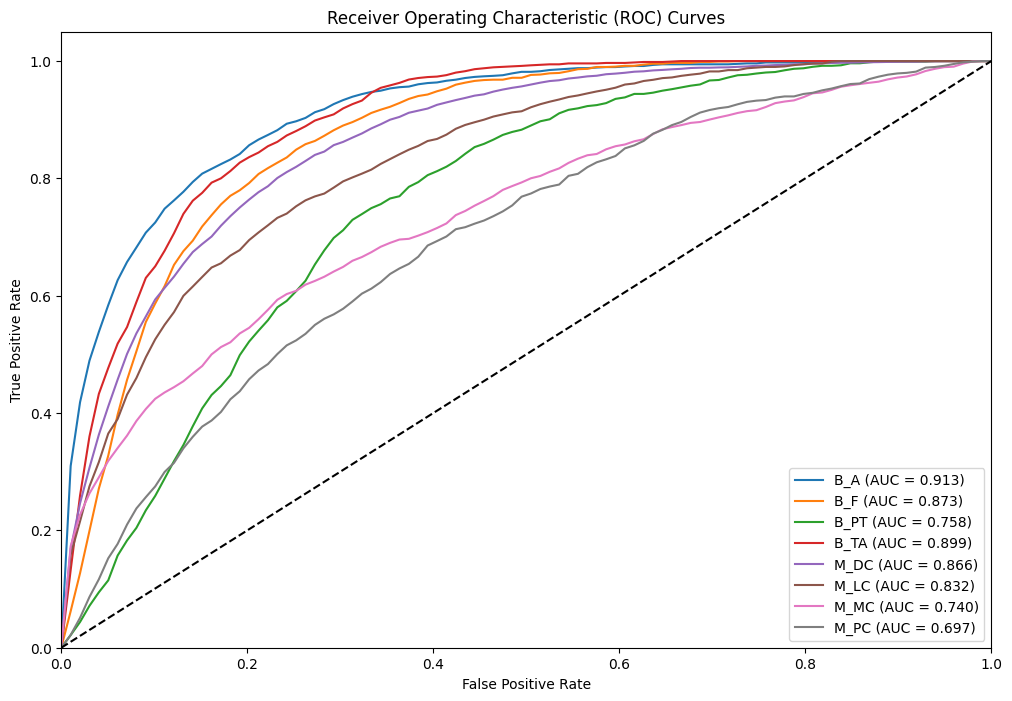

In [29]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels_list):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for y_test_bin, y_pred_prob in zip(all_y_test, all_y_pred_prob):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label=f'{label} (AUC = {mean_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

Hierarchical Classification

In [30]:
import os
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold

# Define the labels and classes
labels_list = ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']
classes = ["adenosis (A)", "fibroadenoma (F)", "phyllodes tumor (PT)", "tubular adenona (TA)", "carcinoma (DC)", "lobular carcinoma (LC)", "mucinous carcinoma (MC)", "papillary carcinoma (PC)"]

# Define the hierarchy
hierarchy = {
    'B': ['B_A', 'B_F', 'B_PT', 'B_TA'],
    'M': ['M_DC', 'M_LC', 'M_MC', 'M_PC']
}

# # Check device availability
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(f"Running on device: {device}")

# # Assuming model is already defined
# # model = ...

# # Move model to GPU if available
# model.to(device)

In [31]:
# Function to extract label from filename
def extract_label_from_filename(filename, labels_list):
    for label in labels_list:
        if label in filename:
            return label
    return None

# Function to load features and labels
def load_features_and_labels(feature_folder, labels_list):
    features = []
    labels = []
    for feature_file in os.listdir(feature_folder):
        if feature_file.endswith("_features.pt"):
            feature_path = os.path.join(feature_folder, feature_file)
            feature = torch.load(feature_path).to('cpu').numpy()
            feature = feature.flatten()
            features.append(feature)
            label = extract_label_from_filename(feature_file, labels_list)
            if label:
                labels.append(label)
    return np.array(features), np.array(labels)

In [32]:
base_fold_path = r"C:\Users\Vivian\Documents\CONCH\Folds"

# Initialize lists to store results
all_y_true = []
all_y_pred = []

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(kf.split(labels_list)):
    train_feature_folder = os.path.join(base_fold_path, f"Fold {fold + 1}", "train_features")
    test_feature_folder = os.path.join(base_fold_path, f"Fold {fold + 1}", "test_features")

    # Load training and testing data
    X_train, y_train = load_features_and_labels(train_feature_folder, labels_list)
    X_test, y_test = load_features_and_labels(test_feature_folder, labels_list)

    # Train first-level classifier (B vs M)
    y_train_level1 = np.array(['B' if label in hierarchy['B'] else 'M' for label in y_train])
    y_test_level1 = np.array(['B' if label in hierarchy['B'] else 'M' for label in y_test])
    
    classifier_level1 = LogisticRegression(max_iter=1000)
    classifier_level1.fit(X_train, y_train_level1)
    
    # Predict first-level classes
    y_pred_level1 = classifier_level1.predict(X_test)
    
    # Train second-level classifiers for each first-level class
    classifiers_level2 = {}
    for parent_class in hierarchy:
        indices = np.where(y_train_level1 == parent_class)[0]
        if len(indices) > 0:
            X_train_level2 = X_train[indices]
            y_train_level2 = y_train[indices]
            classifier_level2 = LogisticRegression(max_iter=1000)
            classifier_level2.fit(X_train_level2, y_train_level2)
            classifiers_level2[parent_class] = classifier_level2
    
    # Predict second-level classes
    y_pred = []
    for i, parent_class in enumerate(y_pred_level1):
        if parent_class in classifiers_level2:
            classifier_level2 = classifiers_level2[parent_class]
            X_test_sample = X_test[i].reshape(1, -1)
            y_pred_sample = classifier_level2.predict(X_test_sample)
            y_pred.append(y_pred_sample[0])
        else:
            y_pred.append(parent_class)  # Default to parent class if no second-level classifier
    
    # Store results
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_29364\1180006393.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_29364\1180006393.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_29364\1180006393.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_29364\1180006393.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_29364\1180006393.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

Accuracy: 0.5376
Classification Report:
                          precision    recall  f1-score   support

            adenosis (A)       0.58      0.44      0.50      1081
        fibroadenoma (F)       0.38      0.58      0.46      1385
    phyllodes tumor (PT)       0.07      0.02      0.03       846
    tubular adenona (TA)       0.51      0.46      0.48      1203
          carcinoma (DC)       0.69      0.82      0.75      5538
  lobular carcinoma (LC)       0.39      0.33      0.36      1203
 mucinous carcinoma (MC)       0.40      0.32      0.35      1514
papillary carcinoma (PC)       0.17      0.13      0.15       895

                accuracy                           0.54     13665
               macro avg       0.40      0.39      0.39     13665
            weighted avg       0.50      0.54      0.51     13665



<Figure size 1200x800 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curves')

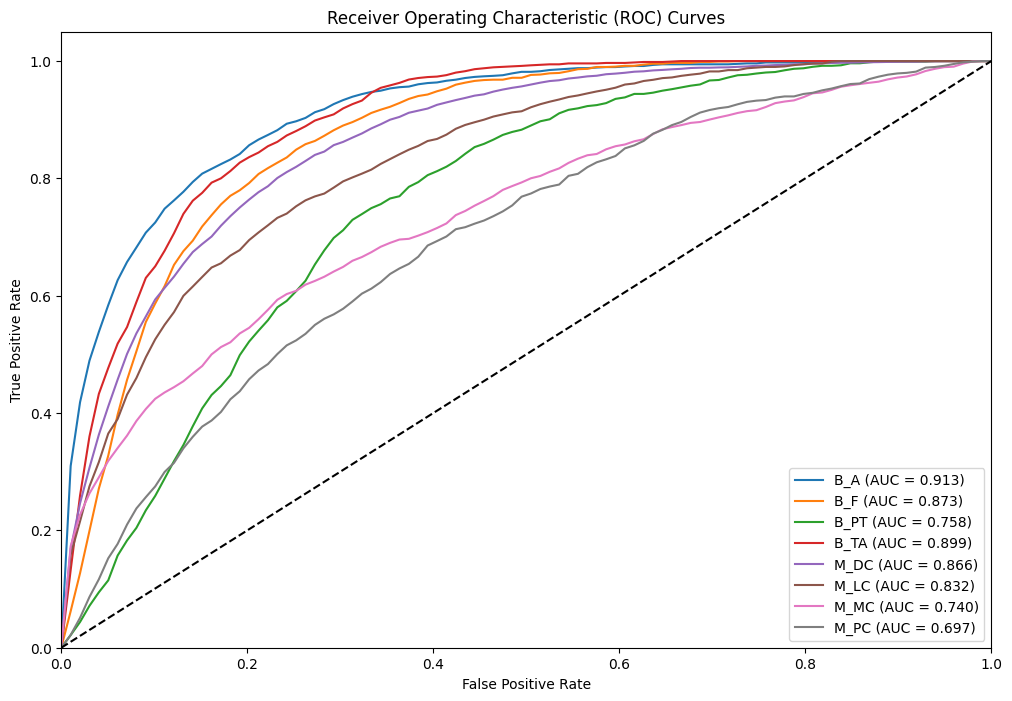

In [33]:
# Generate classification report
def generate_classification_report(true_labels, predicted_labels, classes):
    """
    Generate the classification report.
    Args:
        true_labels (list): List of true labels.
        predicted_labels (list): List of predicted labels.
        classes (list): List of class names.
    
    Returns:
        None
    """
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate classification report
    report = classification_report(true_labels, predicted_labels, target_names=classes)
    print("Classification Report:")
    print(report)

# Example usage
generate_classification_report(all_y_true, all_y_pred, classes)

# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels_list):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for y_test_bin, y_pred_prob in zip(all_y_test, all_y_pred_prob):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label=f'{label} (AUC = {mean_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

hierachical classification pt 2

In [34]:
import os
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold

# Define the labels and classes
labels_list = ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']
classes = ["adenosis (A)", "fibroadenoma (F)", "phyllodes tumor (PT)", "tubular adenona (TA)", "carcinoma (DC)", "lobular carcinoma (LC)", "mucinous carcinoma (MC)", "papillary carcinoma (PC)"]

# Define the hierarchy
hierarchy = {
    'B': ['B_A', 'B_F', 'B_PT', 'B_TA'],
    'M': ['M_DC', 'M_LC', 'M_MC', 'M_PC']
}

# # Check device availability
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(f"Running on device: {device}")

# # Assuming model is already defined
# # model = ...

# # Move model to GPU if available
# model.to(device)

In [35]:
# Function to extract label from filename
def extract_label_from_filename(filename, labels_list):
    for label in labels_list:
        if label in filename:
            return label
    return None

# Function to load features and labels
def load_features_and_labels(feature_folder, labels_list):
    features = []
    labels = []
    for feature_file in os.listdir(feature_folder):
        if feature_file.endswith("_features.pt"):
            feature_path = os.path.join(feature_folder, feature_file)
            feature = torch.load(feature_path).to('cpu').numpy()
            feature = feature.flatten()
            features.append(feature)
            label = extract_label_from_filename(feature_file, labels_list)
            if label:
                labels.append(label)
    return np.array(features), np.array(labels)

In [36]:
base_fold_path = r"C:\Users\Vivian\Documents\CONCH\Folds"

# Initialize lists to store results
all_y_true_level1 = []
all_y_pred_level1 = []
all_y_true_level2 = []
all_y_pred_level2 = []
all_y_test_level1 = []
all_y_pred_prob_level1 = []
all_y_test_level2 = []
all_y_pred_prob_level2 = []

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(kf.split(labels_list)):
    train_feature_folder = os.path.join(base_fold_path, f"Fold {fold + 1}", "train_features")
    test_feature_folder = os.path.join(base_fold_path, f"Fold {fold + 1}", "test_features")

    # Load training and testing data
    X_train, y_train = load_features_and_labels(train_feature_folder, labels_list)
    X_test, y_test = load_features_and_labels(test_feature_folder, labels_list)

    # Train first-level classifier (B vs M)
    y_train_level1 = np.array(['B' if label in hierarchy['B'] else 'M' for label in y_train])
    y_test_level1 = np.array(['B' if label in hierarchy['B'] else 'M' for label in y_test])
    
    classifier_level1 = LogisticRegression(max_iter=1000)
    classifier_level1.fit(X_train, y_train_level1)
    
    # Predict first-level classes
    y_pred_level1 = classifier_level1.predict(X_test)
    y_pred_prob_level1 = classifier_level1.predict_proba(X_test)

    # Train second-level classifiers for each first-level class
    classifiers_level2 = {}
    for parent_class in hierarchy:
        indices = np.where(y_train_level1 == parent_class)[0]
        if len(indices) > 0:
            X_train_level2 = X_train[indices]
            y_train_level2 = y_train[indices]
            classifier_level2 = LogisticRegression(max_iter=1000)
            classifier_level2.fit(X_train_level2, y_train_level2)
            classifiers_level2[parent_class] = classifier_level2
    
    # Predict second-level classes
    y_pred_level2 = []
    y_pred_prob_level2 = []
    for i, parent_class in enumerate(y_pred_level1):
        if parent_class in classifiers_level2:
            classifier_level2 = classifiers_level2[parent_class]
            X_test_sample = X_test[i].reshape(1, -1)
            y_pred_sample = classifier_level2.predict(X_test_sample)
            y_pred_prob_sample = classifier_level2.predict_proba(X_test_sample)
            y_pred_level2.append(y_pred_sample[0])
            y_pred_prob_level2.append(y_pred_prob_sample[0])
        else:
            y_pred_level2.append(parent_class)  # Default to parent class if no second-level classifier
            y_pred_prob_level2.append([1.0, 0.0])  # Dummy probability

    # Store results for first-level classification
    all_y_true_level1.extend(y_test_level1)
    all_y_pred_level1.extend(y_pred_level1)
    all_y_test_level1.append(label_binarize(y_test_level1, classes=['B', 'M']))
    all_y_pred_prob_level1.append(y_pred_prob_level1)

    # Store results for second-level classification
    all_y_true_level2.extend(y_test)
    all_y_pred_level2.extend(y_pred_level2)
    all_y_test_level2.append(label_binarize(y_test, classes=labels_list))
    all_y_pred_prob_level2.append(np.array(y_pred_prob_level2))

C:\Users\Vivian\AppData\Local\Temp\ipykernel_29364\1180006393.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_29364\1180006393.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_29364\1180006393.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_29364\1180006393.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_29364\1180006393.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

LogisticRegression(max_iter=1000)

First-Level Classification Report:
Accuracy: 0.8673
Classification Report:
              precision    recall  f1-score   support

           B       0.82      0.77      0.79      4515
           M       0.89      0.92      0.90      9150

    accuracy                           0.87     13665
   macro avg       0.85      0.84      0.85     13665
weighted avg       0.87      0.87      0.87     13665

Second-Level Classification Report:
Accuracy: 0.5376
Classification Report:
                          precision    recall  f1-score   support

            adenosis (A)       0.58      0.44      0.50      1081
        fibroadenoma (F)       0.38      0.58      0.46      1385
    phyllodes tumor (PT)       0.07      0.02      0.03       846
    tubular adenona (TA)       0.51      0.46      0.48      1203
          carcinoma (DC)       0.69      0.82      0.75      5538
  lobular carcinoma (LC)       0.39      0.33      0.36      1203
 mucinous carcinoma (MC)       0.40      0.32      0.35    

<Figure size 1200x800 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'First-Level Receiver Operating Characteristic (ROC) Curves')

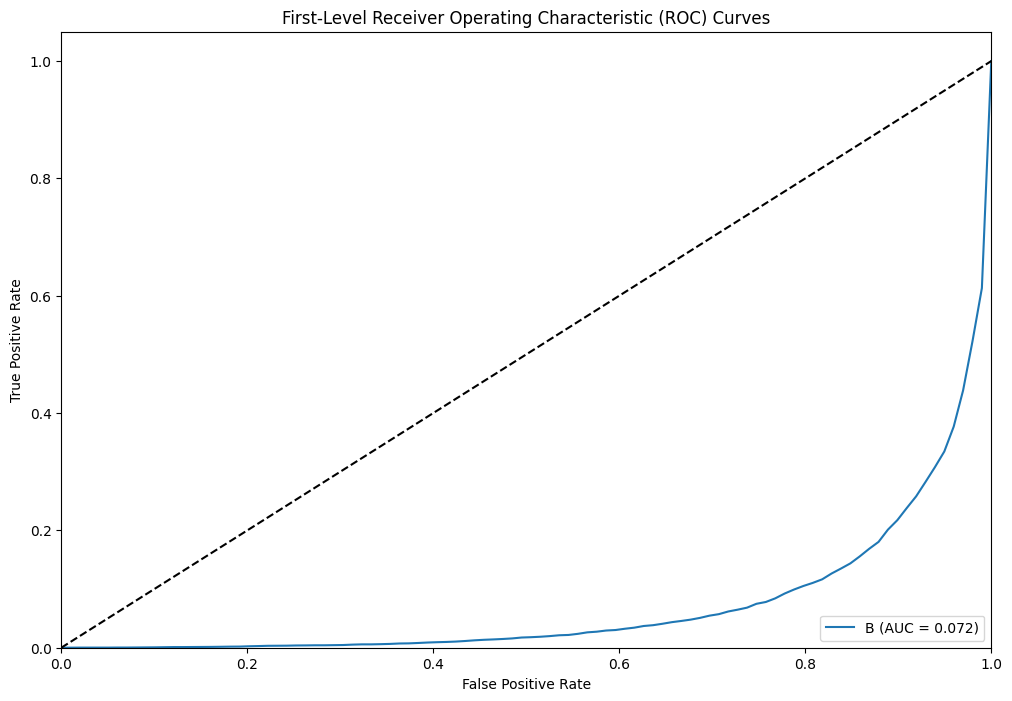

<Figure size 1200x800 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Second-Level Receiver Operating Characteristic (ROC) Curves')

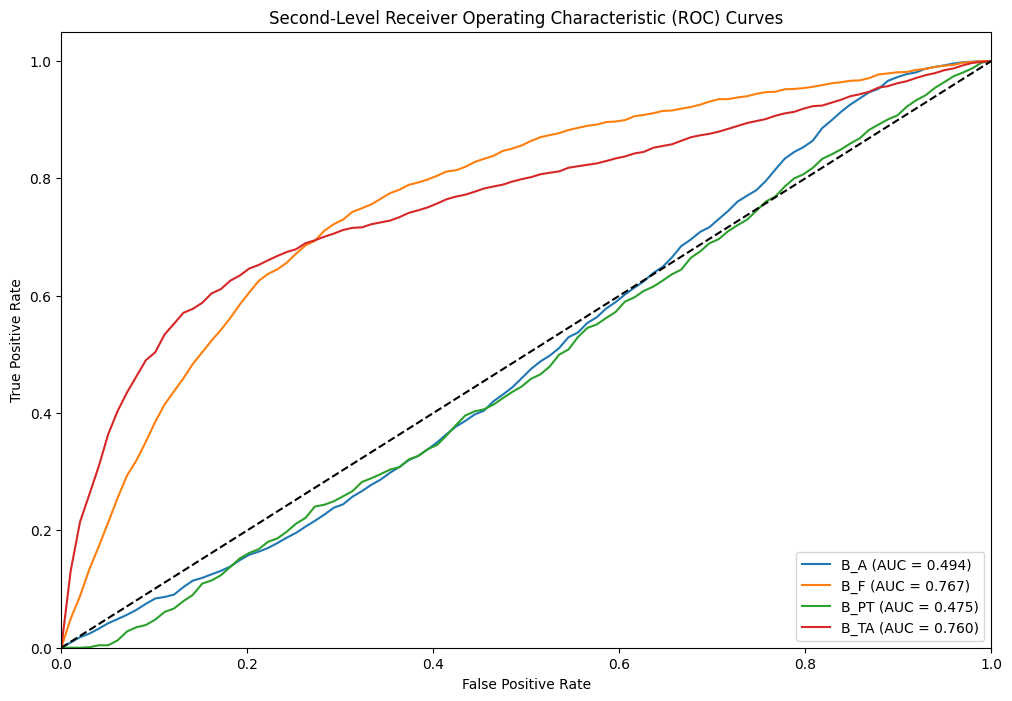

In [39]:
# Generate classification report
def generate_classification_report(true_labels, predicted_labels, classes):
    """
    Generate the classification report.
    Args:
        true_labels (list): List of true labels.
        predicted_labels (list): List of predicted labels.
        classes (list): List of class names.
    
    Returns:
        None
    """
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate classification report
    report = classification_report(true_labels, predicted_labels, target_names=classes)
    print("Classification Report:")
    print(report)

# Example usage for first-level classification
print("First-Level Classification Report:")
generate_classification_report(all_y_true_level1, all_y_pred_level1, ['B', 'M'])

# Example usage for second-level classification
print("Second-Level Classification Report:")
generate_classification_report(all_y_true_level2, all_y_pred_level2, classes)

# Plot ROC curves for first-level classification
plt.figure(figsize=(12, 8))
for i, label in enumerate(['B', 'M']):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for y_test_bin, y_pred_prob in zip(all_y_test_level1, all_y_pred_prob_level1):
        if y_test_bin.shape[1] > i and y_pred_prob.shape[1] > i:
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
    if tprs:
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, label=f'{label} (AUC = {mean_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('First-Level Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

# Plot ROC curves for second-level classification
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels_list):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for y_test_bin, y_pred_prob in zip(all_y_test_level2, all_y_pred_prob_level2):
        if y_test_bin.shape[1] > i and y_pred_prob.shape[1] > i:
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
    if tprs:
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, label=f'{label} (AUC = {mean_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Second-Level Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

In [4]:
# check if this code is running on my cpu or gpu
import torch
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 4070 SUPER'

K-fold updated?

In [1]:
import os
import numpy as np
import torch
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Define the labels
labels_list_full = ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']
labels_list = [0 if label.startswith('B') else 1 for label in labels_list_full]

# Function to extract label from filename
def extract_label_from_filename(filename):
    for subtype in labels_list_full:
        if subtype in filename:
            cancer = 0 if subtype.startswith('B') else 1
            return cancer, subtype
    return None

def load_features_and_labels(feature_folder):
    features = []
    cancer_labels = []
    subtype_labels = []
    for feature_file in os.listdir(feature_folder):
        if feature_file.endswith("_features.pt"):
            feature_path = os.path.join(feature_folder, feature_file)
            feature = torch.load(feature_path).to('cpu').numpy()
            feature = feature.flatten()
            features.append(feature)
            cancer_label, subtype_label = extract_label_from_filename(feature_file)
            if cancer_label is not None:
                cancer_labels.append(cancer_label)
            if subtype_label is not None:
                subtype_labels.append(subtype_label)
    return np.array(features), np.array(cancer_labels), np.array(subtype_labels)



In [2]:
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Paths
# base_fold_path = r"C:\Users\Kaito\OneDrive - Queen's University\School\Data\Folds"
base_fold_path = r"C:\Users\Vivian\Documents\CONCH\Folds"
# Assuming labels_list_full contains all possible subtypes
all_subtypes = labels_list_full  # List of all 8 labels

# Initialize lists to store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []
all_fpr = {label: [] for label in all_subtypes}
all_tpr = {label: [] for label in all_subtypes}
classification_reports = []

# Initialize LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(all_subtypes)

# Loop through each fold
for fold in range(1, 6):
    print(f"Processing Fold {fold}...")
    
    train_feature_folder = os.path.join(base_fold_path, f"Fold {fold}", "train_features")
    test_feature_folder = os.path.join(base_fold_path, f"Fold {fold}", "test_features")

    # Load training and testing data
    X_train, _, subtype_train = load_features_and_labels(train_feature_folder)
    X_test, _, subtype_test = load_features_and_labels(test_feature_folder)

    # Encode subtype labels
    subtype_train_encoded = label_encoder.transform(subtype_train)
    subtype_test_encoded = label_encoder.transform(subtype_test)

    # Train logistic regression classifier for all subtypes using OneVsRestClassifier
    classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    classifier.fit(X_train, subtype_train_encoded)

    # Predict on test data for all subtypes
    y_pred_subtype = classifier.predict(X_test)
    y_pred_prob_subtype = classifier.predict_proba(X_test)

    # Binarize the test labels for ROC AUC calculation
    subtype_test_binarized = label_binarize(subtype_test_encoded, classes=label_encoder.transform(all_subtypes))

    # Calculate metrics for the current fold
    accuracy = accuracy_score(subtype_test_encoded, y_pred_subtype)
    precision = precision_score(subtype_test_encoded, y_pred_subtype, average='weighted')
    recall = recall_score(subtype_test_encoded, y_pred_subtype, average='weighted')
    f1 = f1_score(subtype_test_encoded, y_pred_subtype, average='weighted')
    roc_auc = roc_auc_score(subtype_test_binarized, y_pred_prob_subtype, average='weighted', multi_class='ovr')
    
    # Store metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)
    
    # Calculate ROC curve for the current fold
    for i, label in enumerate(all_subtypes):
        fpr, tpr, _ = roc_curve(subtype_test_binarized[:, i], y_pred_prob_subtype[:, i])
        all_fpr[label].append(fpr)
        all_tpr[label].append(tpr)
    
    # Generate classification report for the current fold
    report = classification_report(subtype_test_encoded, y_pred_subtype, target_names=all_subtypes, output_dict=True)
    classification_reports.append(report)
    
    print(f"Fold {fold} complete.")

# Calculate average metrics
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)
avg_roc_auc = np.mean(roc_aucs)

# Print average results
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average ROC AUC: {avg_roc_auc:.4f}")


Processing Fold 1...


C:\Users\Vivian\AppData\Local\Temp\ipykernel_15092\374651647.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


Fold 1 complete.
Processing Fold 2...


C:\Users\Vivian\AppData\Local\Temp\ipykernel_15092\374651647.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


Fold 2 complete.
Processing Fold 3...


C:\Users\Vivian\AppData\Local\Temp\ipykernel_15092\374651647.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


Fold 3 complete.
Processing Fold 4...


C:\Users\Vivian\AppData\Local\Temp\ipykernel_15092\374651647.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


Fold 4 complete.
Processing Fold 5...


C:\Users\Vivian\AppData\Local\Temp\ipykernel_15092\374651647.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path).to('cpu').numpy()


Fold 5 complete.
Average Accuracy: 0.5350
Average Precision: 0.5145
Average Recall: 0.5350
Average F1 Score: 0.5072
Average ROC AUC: 0.8301



Average Classification Report:
B_A:
  precision: 0.6256
  recall: 0.4458
  f1-score: 0.5074
  support: 216.2000
B_F:
  precision: 0.3756
  recall: 0.5662
  f1-score: 0.4498
  support: 277.0000
B_PT:
  precision: 0.0869
  recall: 0.0336
  f1-score: 0.0404
  support: 169.2000
B_TA:
  precision: 0.4799
  recall: 0.4461
  f1-score: 0.4584
  support: 240.6000
M_DC:
  precision: 0.6877
  recall: 0.8257
  f1-score: 0.7479
  support: 1107.6000
M_LC:
  precision: 0.4342
  recall: 0.3161
  f1-score: 0.3434
  support: 240.6000
M_MC:
  precision: 0.3965
  recall: 0.3007
  f1-score: 0.3286
  support: 302.8000
M_PC:
  precision: 0.1889
  recall: 0.1020
  f1-score: 0.1196
  support: 179.0000


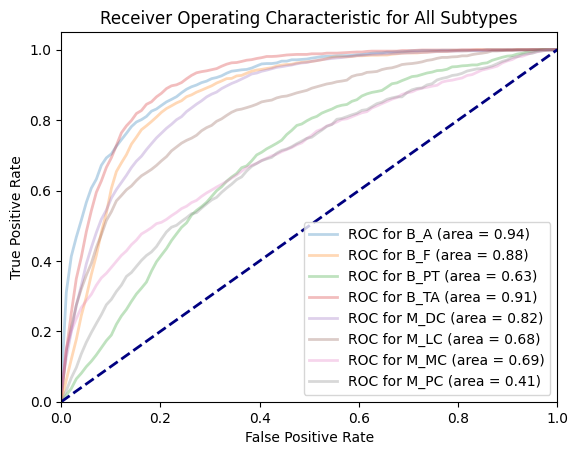

In [3]:

# Calculate average classification report (i put avg_report into chat to make me a table)
avg_report = {}
for label in all_subtypes:
    avg_report[label] = {}
    for metric in ['precision', 'recall', 'f1-score', 'support']:
        avg_report[label][metric] = np.mean([report[label][metric] for report in classification_reports])

# Print average classification report
print("\nAverage Classification Report:")
for label, metrics in avg_report.items():
    print(f"{label}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Plot average ROC curve
plt.figure()
for label in all_subtypes:
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, all_fpr[label][j], all_tpr[label][j]) for j in range(len(all_fpr[label]))], axis=0)
    plt.plot(mean_fpr, mean_tpr, lw=2, alpha=0.3, label=f'ROC for {label} (area = {roc_auc_score(subtype_test_binarized[:, all_subtypes.index(label)], y_pred_prob_subtype[:, all_subtypes.index(label)]):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for All Subtypes')
plt.legend(loc="lower right")
plt.show()

Attempting Finetuning with the BreakHis Dataset